In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
batch_size = 64
block_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 384
n_heads = 6
n_layers = 6
dropout = 0.2

## Getting the data

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-11-25 04:59:51--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-11-25 04:59:51 (22.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



## Defining Vocabulary

In [ ]:
with open('input.txt','r',encoding='utf-8') as f:
    text=f.read()

chars=sorted(list(set(text)))
vocab_size=len(chars)
ctoi={ch:i for i,ch in enumerate(chars)}
itoc={i:ch for i,ch in enumerate(chars)}
encode=lambda s: [ctoi[c] for c in s]
decode=lambda l: ''.join([itoc[i] for i in l])

In [ ]:
data=torch.tensor(encode(text),dtype=torch.long)
n=int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

In [ ]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix=torch.randint(len(data)-block_size,(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix])
    y=torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y=x.to(device),y.to(device)
    return x,y



## Define model architechture

In [ ]:
class Head(nn.Module):
    def __init__(self,head_size):
        super(Head,self).__init__()
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query=nn.Linear(n_embd,head_size,bias=False)
        self.value=nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self,x):
        B,T,C=x.shape
        k=self.key(x)
        q=self.query(x)
        wei=q@k.transpose(-2,-1)*k.shape[-1]**-0.5
        wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei=F.softmax(wei,dim=-1)
        wei=self.dropout(wei)
        v=self.value(x)
        out=wei@v
        return out

In [ ]:
class MultiHead(nn.Module):
    def __init__(self,n_heads,head_size):
        super(MultiHead,self).__init__()
        self.heads=nn.ModuleList(Head(head_size) for _ in range(n_heads))
        self.proj=nn.Linear(n_heads*head_size,n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x):
        out=torch.cat([h(x) for h in self.heads],dim=-1)
        out=self.dropout(self.proj(out))
        return out

In [ ]:
class MLP(nn.Module):
    def __init__(self,n_embd):
        super(MLP,self).__init__()
        self.network=nn.Sequential(
            nn.Linear(n_embd,4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd,n_embd),
            nn.Dropout(dropout)
        )
    def forward(self,x):
        return self.network(x)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self,n_embd,n_heads):
        super(TransformerBlock,self).__init__()
        head_size=n_embd//n_heads
        self.attn=MultiHead(n_heads,head_size)
        self.mlp=MLP(n_embd)
        self.l1=nn.LayerNorm(n_embd)
        self.l2=nn.LayerNorm(n_embd)
    def forward(self,x):
        out=x+self.attn(self.l1(x))
        out=out + self.mlp(self.l2(out))
        return out

In [ ]:
class GPTModel(nn.Module):
    def __init__(self):
        super(GPTModel,self).__init__()
        self.embedding_table=nn.Embedding(vocab_size,n_embd)
        self.pos_embedding_table=nn.Embedding(block_size,n_embd)
        self.blocks=nn.Sequential(*[TransformerBlock(n_embd,n_heads) for _ in range(n_layers)])
        self.lf=nn.LayerNorm(n_embd)
        self.lm=nn.Linear(n_embd,vocab_size)

        self.apply(self.init_weights)

    def init_weights(self,module):
        if isinstance (module,nn.Linear):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance (module,nn.Embedding):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)

    def forward(self,idx,targets=None):
        B,T=idx.shape
        tok_emb=self.embedding_table(idx)
        pos_emb=self.pos_embedding_table(torch.arange(T,device=device))
        x=tok_emb+pos_emb
        x=self.blocks(x)
        x=self.lf(x)
        logits=self.lm(x)
        if targets==None:
            loss=None
        else:
            B,T,C=logits.shape
            logits=logits.view(B*T,C)
            targets=targets.view(B*T)
            loss=F.cross_entropy(logits,targets)
        return logits,loss

    def generate(self,idx,max_tokens):
        for _ in range(max_tokens):
            idx_cond=idx[:,-block_size:]
            logits,loss=self(idx_cond)
            logits=logits[:,-1,:]
            probs=F.softmax(logits,dim=-1)
            idx_next=torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx,idx_next),dim=1)
        return idx


## Define the train and eval functions

In [ ]:
@torch.no_grad()
def evaluate(eval_iters,model,val_data):
    model.eval()
    result={}
    iter_loss=[]
    for _ in range(eval_iters):
        x,y=get_batch(val_data)
        logits,loss=model(x,y)
        iter_loss.append(loss)
    avg_loss=torch.stack(iter_loss).mean()
    result['val_loss']=avg_loss
    model.train()
    return result

def train(max_iter,eval_iters,model,lr,train_data,val_data,optim_func):
    history=[]
    optimizer = optim_func(model.parameters(), lr=lr)
    train_losses=[]
    for iters in range(max_iter):
        x,y=get_batch(train_data)
        logits,loss=model(x,y)
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if iters%500==0:
            result=evaluate(eval_iters,model,val_data)
            result['train_loss']=torch.stack(train_losses).mean()
            print(f'train_loss:{result["train_loss"]},val_loss:{result["val_loss"]}')
            train_losses=[]
            history.append(result)
    return history

In [ ]:
model=GPTModel()
model=model.to(device)

In [ ]:
optim_func=torch.optim.AdamW
lr = 1e-4
max_iters=10000
eval_iters=200

## Train the model

In [ ]:
history=train(max_iters,eval_iters,model,lr,train_data,val_data,optim_func)

train_loss:4.281167984008789,val_loss:3.675260543823242
train_loss:2.4042160511016846,val_loss:2.106052875518799
train_loss:1.881987452507019,val_loss:1.4840264320373535
train_loss:1.4526076316833496,val_loss:1.0489177703857422
train_loss:1.1085741519927979,val_loss:0.572697103023529
train_loss:0.766722559928894,val_loss:0.2480648308992386
train_loss:0.5081079006195068,val_loss:0.1327822357416153
train_loss:0.3606354892253876,val_loss:0.10057030618190765
train_loss:0.28069138526916504,val_loss:0.0888681560754776
train_loss:0.23414693772792816,val_loss:0.08103197813034058
train_loss:0.20386041700839996,val_loss:0.07563679665327072
train_loss:0.1816793978214264,val_loss:0.07181049883365631
train_loss:0.16611109673976898,val_loss:0.06966103613376617
train_loss:0.153518944978714,val_loss:0.06632494181394577
train_loss:0.14430157840251923,val_loss:0.06433387845754623
train_loss:0.1356486976146698,val_loss:0.06220502778887749
train_loss:0.1289178729057312,val_loss:0.061020396649837494
train_

In [ ]:
text="What's in a name?"
context=torch.tensor(encode(text),dtype=torch.long,device=device).unsqueeze(0)
print(context)

tensor([[35, 46, 39, 58,  5, 57,  1, 47, 52,  1, 39,  1, 52, 39, 51, 43, 12]],
       device='cuda:0')


## Inference

In [ ]:
print(decode(model.generate(context,max_tokens=1000)[0].tolist()))

What's in a name?

LUCENTIO:
O, Biondello, bid your mistress come to me.

BIONDELLO:
I go.

BAPTISTA:
Sir, what I halm not Lucentio.

BIONDELLO:
When I am an will he meant with you, sir?

BIONDELLO:
Whatere is say well with her and she come bnot her.

BAPTISTA:
And, then thou hast not say with her comes?

BIONDELLO:
Why, not, Petruchio is coming in a new hat and here in heare
looks for prayers; and there, thou shouldst knowing
Out of whence and crawling
I am at hund were 'tis name on how
To ne halft the fingeren bet least.

VINCENTIO:
And what of him, Say irst should find.

GONZALO:
Who is good Lord, be not to hores with a brought she
be cut and such ass your
Doth an old to him her lush.

MIRANDA:
Why, as my and here looks and to tale in Marself
That the winds of coulding the parkets
With hin feard with sair: then I have follow'd to name forthwith,
To dress my shall and and gossed ther than tere than the hee,
But his frome; though she hard never I feauty,
Whose enter from know her beau

In [ ]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

10.788929 M parameters


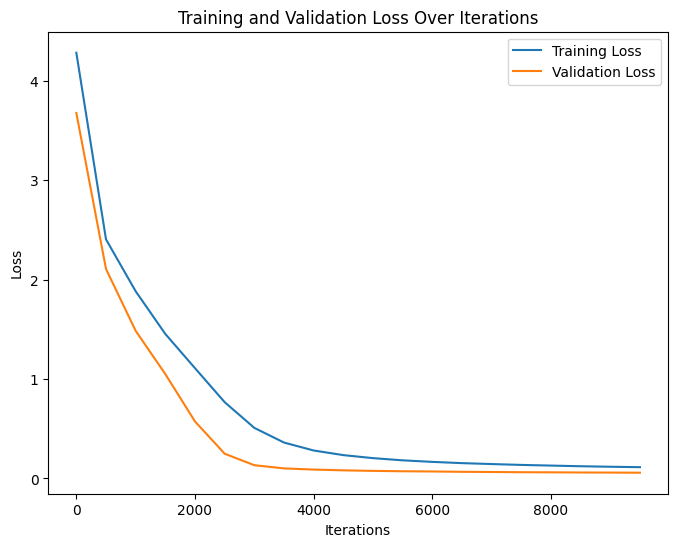

In [ ]:
import matplotlib.pyplot as plt

# Extracting values
train_loss = [history[i]['train_loss'].item() for i in range(len(history))]
val_loss = [history[i]['val_loss'].item() for i in range(len(history))]

iterations = range(0, 500*len(train_loss),500)

# Plotting the learning curves
plt.figure(figsize=(8, 6))
plt.plot(iterations, train_loss, label='Training Loss')
plt.plot(iterations, val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Iterations')
plt.legend()

# Display the plot
plt.show()


In [ ]:
torch.save(model.state_dict(), 'GPTmodel_weights.pth')